In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gen = pd.read_csv('gender.csv', index_col=0)

In [3]:
fem = gen[gen['Gender']==0]
mal = gen[gen['Gender']==1]

In [4]:
def create_survival_df(male_df, female_df, column, interval):
    surv_df = pd.DataFrame(columns = ['male', 'female'])
    for i in np.arange(0,male_df[column].max()+1, interval):
        surv_df.loc[i,'male'] = male_df[male_df[column]>=i].shape[0]/male_df.shape[0]
        surv_df.loc[i,'female'] = female_df[female_df[column]>=i].shape[0]/female_df.shape[0]
    surv_df.reset_index(inplace=True)
    return surv_df

In [5]:
surv_exper_df = create_survival_df(mal, fem, 'Exper', 1)
surv_sal94_df = create_survival_df(mal, fem, 'Sal94', 10000)

In [6]:
# make list of surv_dfs, with each dept as individual dataframe
surv_dfs = []
for dept in gen.Dept.unique():
    male_df = mal[mal.Dept == dept]
    fem_df = fem[fem.Dept == dept]
    df1 = create_survival_df(male_df, fem_df, 'Sal94', 10000)
    surv_dfs.append(df1)

Text(0.5, 1.0, 'Survival Curve: Experience in years')

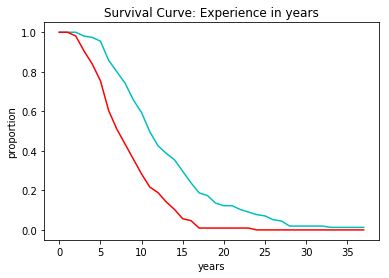

In [7]:
# survival curve: years of experience
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_exper_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_exper_df, color='r', ax=ax)
ax.set_xlabel('years')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Experience in years')

In [8]:
'''for each female, use a limited range of years of experience to find matched males'''
def create_linked_exper(fem_df, mal_df):
    linked_list = []
    x=0
    for f, frow in fem.iterrows():
        low = frow.Exper*.8
        high = frow.Exper*1.2
        matched_mal = mal[(mal['Exper'] < high) & (mal['Exper'] > low)]

        if matched_mal.shape[0]==0:
            continue

        for m, mrow in matched_mal.iterrows():
            linked_list.append((frow.ID, mrow.ID))
    linked_df = pd.DataFrame(linked_list, columns= ['female_id', 'male_id'])
    return linked_df
linked_df = create_linked_exper(fem, mal)

In [ ]:
# sample salary from men matched to women on some critera
# create permutation dataframes: sampled salaries & survival curve props
def create_perm_dfs(gen_df, linked_ids, salary_col, interval, nperms):
    all_samps = pd.DataFrame()
    all_props = pd.DataFrame()
    for i in range(0,nperms):
        samp_df = linked_ids.sample(frac=1).drop_duplicates(subset = 'female_id')
        all_samps.loc[:,i] = gen_df.loc[samp_df['male_id']].reset_index()[salary_col]

    # create proportions for survival curve
        for ind in np.arange(0,gen_df[salary_col].max()+1, interval):
            all_props.loc[ind,i] = all_samps[all_samps[i]>=ind].shape[0]/all_samps.shape[0]
    return all_props

In [ ]:
all_props_exper = create_perm_dfs(gen, linked_df, 'Sal94', 10000, 1000)
# calculate 95% confidence intervals
mins = all_props_exper.quantile(.025, axis=1)
maxes = all_props_exper.quantile(.975, axis=1)

Text(0.5, 1.0, 'Survival Curve: Salary, Matched on years of Experience')

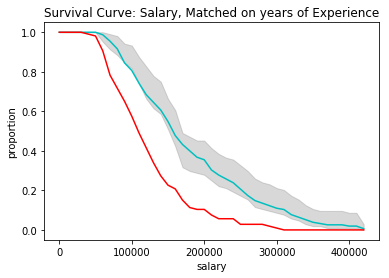

In [15]:
# survival curve: years of experience
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_sal94_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_sal94_df, color='r', ax=ax)
plt.fill_between(x=all_props_exper.index.values, y1=mins, y2=maxes, alpha=.3, color='gray')
ax.set_xlabel('salary')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Salary, Matched on years of Experience')

In [20]:
'''for each female, use a limited range of years of experience to find matched males'''
''' and matched by department'''
def create_linked_plus(fem_df, mal_df, main_crit, other_matched_crit):
    linked_dfs = []
    for val in fem[other_matched_crit].unique():
        linked_list = []

        fem_short = fem[fem[other_matched_crit] == val]
        mal_short = mal[mal[other_matched_crit] == val]

        for f, frow in fem_short.iterrows():
            low = frow[main_crit]*.8
            high = frow[main_crit]*1.2
            matched_mal = mal_short[(mal_short[main_crit] < high) & (mal_short[main_crit] > low)]

            if matched_mal.shape[0]==0:
                continue

            for m, mrow in matched_mal.iterrows():
                linked_list.append((frow.ID, mrow.ID))
        linked_df = pd.DataFrame(linked_list, columns= ['female_id', 'male_id'])
        linked_dfs.append(linked_df)
    return linked_dfs
linked_dfs = create_linked_plus(fem, mal, 'Exper', 'Dept')

In [21]:
dept_names = ['Biochem/Mol Bio', 'Physiology', 'Genetics', 'Pediatrics', 'Medicine', 'Surgery']
dept_labels = dict(zip(range(1,7), dept_names))

In [22]:
# run permutations for each department separately
dept_props = []
for i in range(0,len(linked_dfs)):
    all_props= create_perm_dfs(gen, linked_dfs[i], 'Sal94', 10000, 1000)
    dept_props.append(all_props)

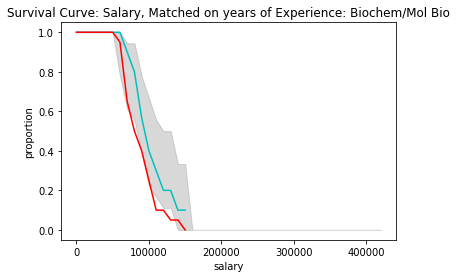

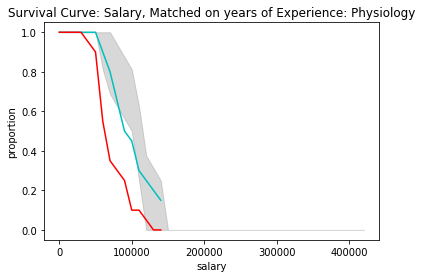

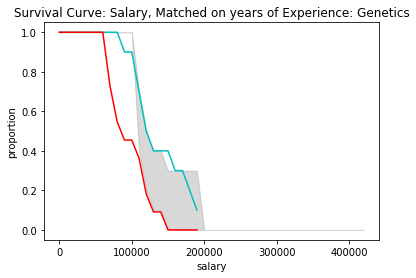

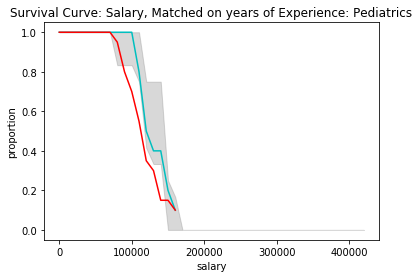

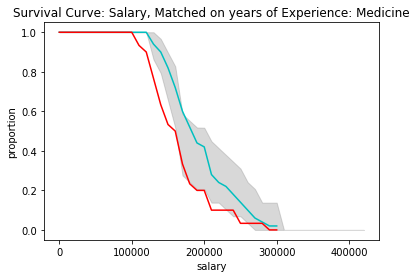

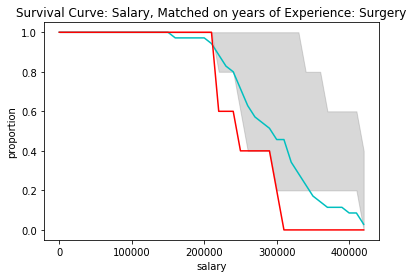

In [23]:
for dept in range(0,len(dept_props)):
    dept_name = dept_labels[dept+1]
    
    # calculate 95% confidence intervals
    mins = dept_props[dept].quantile(.025, axis=1)
    maxes = dept_props[dept].quantile(.975, axis=1)

    # survival curve
    fig, ax = plt.subplots()
    sns.lineplot(x='index', y='male', data=surv_dfs[dept], color='c', ax=ax)
    sns.lineplot(x='index', y='female', data=surv_dfs[dept], color='r', ax=ax)
    plt.fill_between(x=dept_props[dept].index.values, y1=mins, y2=maxes, alpha=.3, color='gray')
    ax.set_xlabel('salary')
    ax.set_ylabel('proportion')
    plt.title(f'Survival Curve: Salary, Matched on years of Experience: {dept_name}')